In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.io import loadmat  # this is the module that loads mat-files

plt.rcParams['figure.figsize'] = [15, 8]
#%matplotlib inline

In [2]:
def read_file_into_df(f_name):
    """ 
    Reads data from one .mat file into a DataFrame.
    Expects data files to be in the root/data_raw folder. 
    """
    
    mat = loadmat(f"data_raw/{f_name}")
    df = pd.DataFrame(mat['data'])
    df.columns = ['time_sec', 'time_microsec', 'signal_horizontal', 'signal_vertical', 'class']
    
    df['time_full'] = df['time_sec'] + (df['time_microsec'] / 1_000_000)
    #df['time_full_str'] = df['time_full_str'].astype(str)
    df = df[['time_sec','time_microsec','time_full','signal_horizontal','signal_vertical','class']]
    
    return df

def read_all_files():
    """
    Reads all data files into DataFrames and puts them into a 2D dictionary.
    To access a file, the first key is the participant (1 - 8), second key is the experiment (0, 1).
    Example: to get the data from the first experiment of participant 5, use dict[5][0]
    """
    
    d = {}
    
    for participant in range(1, 9):
        d[participant] = {}
        
        for experiment in range(0, 2):
            d[participant][experiment] = read_file_into_df(f"participant{participant}_{experiment}.mat")       
    return d

def all_datasets_read_correctly(d):
    """ Checks if all datasets were read correctly (all datasets contain all classes). """
    
    nr_of_datasets = 0
    
    for p in range(1, 9): # participant
        p_dict = d[p]
    
        for e in range(0, 2): # experiment
            e_dict = p_dict[e]
            labels = e_dict['class'].unique()
            
            for c in range(1, 9): # class label
                if c not in labels:
                    print(f"Class {c} not found in participant {p} experiment {e}!")
                    return
            nr_of_datasets += 1
    print("Looks good! All experiments contain all classes.")
    print(f"Total {nr_of_datasets} datasets from 16 experiments.")
    
def print_dataset_sizes(d):
    for participant, exps in d.items():
        for experiment, data in exps.items():
            print(f"participant:{participant}   experiment:{experiment}   total rows:{len(data.index)}")
            
            for class_label in range(1, 9):
                df_class = data[data['class'] == class_label]
                print(f"\t\t     class:{class_label}   nr of rows:{len(df_class.index)}")
                
            print()
            
def machine_measuring_consistency(d):
    stds = np.array([])
    means = np.array([])

    for participant, exps in d.items():
        for experiment, data in exps.items():
            print(f"participant:{participant}   experiment:{experiment}")

            for class_label in range(1, 9):
                class_df = data[data['class'] == class_label]
                measurements = np.asarray(class_df['time_full'])
                helper = np.insert(measurements, 0, 0)

                last = measurements[-1]
                measurements = np.append(measurements, last)

                timediffs = np.asarray(measurements - helper)[1:-1]
                std = round(np.std(timediffs), 4)
                mean = round(np.mean(timediffs), 4)
                print(f"\tclass:{class_label}   measuring time std:{std} (sec)   mean:{mean} (sec)")
                stds = np.append(stds, std)
                means = np.append(means, mean)
            print()

    print(f"Mean std: {np.mean(stds)}")
    print(f"Mean mean: {np.mean(means)}")
    
def plot_column_with_class_colors(x, y, dataset_dict, participant, experiment, col_name):
    color_dict = {1:'darkorange', 
                  2:'lime', 
                  3:'red', 
                  4:'cyan', 
                  5:'magenta', 
                  6:'darkgoldenrod', 
                  7:'black', 
                  8:'gold'}
    colors = [color_dict[class_] for class_ in dataset_dict[participant][experiment]['class']]
    plt.scatter(x, y, s=0.1, c=colors)
    plt.legend(handles=[mpatches.Patch(color=color, label=class_) for class_, color in color_dict.items()])

In [3]:
# Reads all datasets into 2D dict.
# First key is participant nr (1 - 8), second is experiment nr (0, 1)
dataset_dict = read_all_files()

# Example use
participant1_experiment0_data = dataset_dict[1][0]

# Do all datasets contain all classes?
all_datasets_read_correctly(dataset_dict)
print('\n=========================================\n')

# Data sample, columns, and their datatypes
print(f"Participant 1 experiment 0 data sample:\n\n{participant1_experiment0_data.head(5)}\n")
print(f"Columns and their data types: \n{participant1_experiment0_data.dtypes}")
print('\n=========================================\n')

# Sizes of datasets.
# Smallest class size belongs to participant 1, experiment 0, class 7; has only 398 rows
print_dataset_sizes(dataset_dict)
print('On average, 187k rows of data per experiment, 23k per class.')
print('\n=========================================\n')

# How consistent the machine's measuring time was?
print('Average standard deviation of the gap between each measurement in each class of each experiment\n')
machine_measuring_consistency(dataset_dict)
print('\n=========================================\n')

Looks good! All experiments contain all classes.
Total 16 datasets from 16 experiments.


Participant 1 experiment 0 data sample:

     time_sec  time_microsec     time_full  signal_horizontal  \
0  1237450899         488784  1.237451e+09             693553   
1  1237450899         499103  1.237451e+09             692383   
2  1237450899         499143  1.237451e+09             692769   
3  1237450899         519098  1.237451e+09             693178   
4  1237450899         519137  1.237451e+09             693718   

   signal_vertical  class  
0           544925      3  
1           545154      3  
2           544217      3  
3           546028      3  
4           547631      3  

Columns and their data types: 
time_sec               int32
time_microsec          int32
time_full            float64
signal_horizontal      int32
signal_vertical        int32
class                  int32
dtype: object


participant:1   experiment:0   total rows:97742
		     class:1   nr of rows:16299
		    

	class:1   measuring time std:0.0099 (sec)   mean:0.0079 (sec)
	class:2   measuring time std:0.0906 (sec)   mean:0.0109 (sec)
	class:3   measuring time std:0.1732 (sec)   mean:0.0105 (sec)
	class:4   measuring time std:0.0282 (sec)   mean:0.0146 (sec)
	class:5   measuring time std:0.0099 (sec)   mean:0.0079 (sec)
	class:6   measuring time std:0.0088 (sec)   mean:0.0078 (sec)
	class:7   measuring time std:0.0114 (sec)   mean:0.0081 (sec)
	class:8   measuring time std:0.01 (sec)   mean:0.0079 (sec)

participant:5   experiment:0
	class:1   measuring time std:0.013 (sec)   mean:0.0083 (sec)
	class:2   measuring time std:0.1376 (sec)   mean:0.0085 (sec)
	class:3   measuring time std:0.0158 (sec)   mean:0.0093 (sec)
	class:4   measuring time std:0.0094 (sec)   mean:0.0078 (sec)
	class:5   measuring time std:0.2327 (sec)   mean:0.0091 (sec)
	class:6   measuring time std:0.015 (sec)   mean:0.009 (sec)
	class:7   measuring time std:0.0196 (sec)   mean:0.0122 (sec)
	class:8   measuring time std:

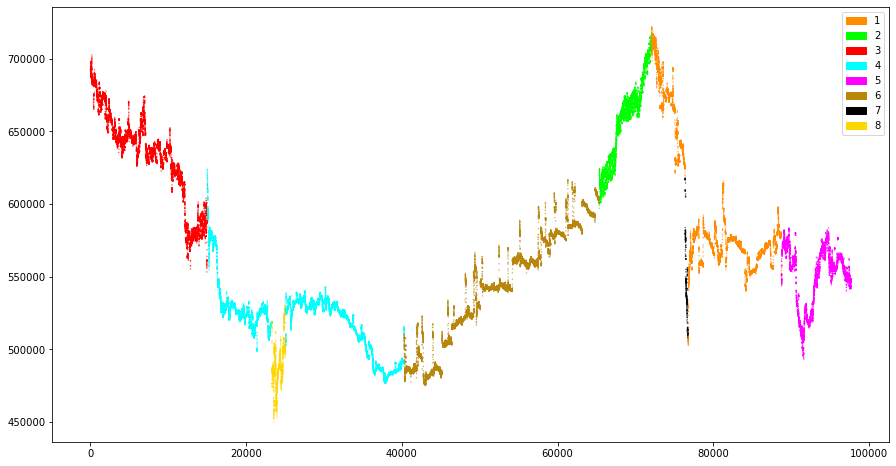

In [8]:
# For checking how classes are arranged in a dataset
participant, experiment, col_name = 1, 0, 'signal_horizontal'

plot_column_with_class_colors(x = np.arange(0, len(dataset_dict[participant][experiment][col_name].index), 1), 
                              y = dataset_dict[participant][experiment][col_name], 
                              dataset_dict = dataset_dict, 
                              participant = participant, 
                              experiment = experiment, 
                              col_name = col_name)